In [ ]:
from analysis_utils import top_activations, prompt_search_mean_local, prompt_search_rank, influence, cosine_similarity_search
from plot_utils import examples_plot_df, examples_plot_df_horizontal, examples_plot_anthropic, plot_UMAP
from autoencoder import SparseAutoencoder

In [2]:
import json
import glob
import torch
import numpy as np

In [3]:
from transformers import AutoModelForCausalLM, AutoTokenizer, BitsAndBytesConfig

In [4]:
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

In [5]:
indicies = [32026, 57660, 45783, 41517, 64668, 29073, 14701, 6527, 49447, 52757, 9720, 50479, 6949, 17260, 64775,  25398]
top_examples = top_activations(
    feat_idx_list=indicies,
    k=20,
    context_len=15,
    latent_dataset_path="../sparse_latent_vectors/latent_vectors_batch_*.pt",
    dataset_slice=(5,50),
    act_id_dataset="../activations_data/last3_batch_*.npy",
    tokenizer=tokenizer,
    verbose=True
)

Top 20 activations for feature index 32026 across all files:
File: ../sparse_latent_vectors/latent_vectors_batch_1_minibatch_9.pt
Target token: ' results'
Activation value: 4.573524475097656
Context: Management of ventricular tachycardia in the ablation era: results of the European Heart Rhythm Association Survey.Patients with sustained ventricular t

File: ../sparse_latent_vectors/latent_vectors_batch_0_minibatch_8.pt
Target token: ' was'
Activation value: 4.473413467407227
Context: : in vitro measurements and in vivo results in 30 patients.Our goal was to evaluate the ability of MR cholangiography to show stent position

File: ../sparse_latent_vectors/latent_vectors_batch_0_minibatch_15.pt
Target token: ' to'
Activation value: 4.204982280731201
Context:  delivery route and congenital hip dislocation.The purpose of this study was to investigate whether the mode of delivery for fetuses in breech presentation in any

File: ../sparse_latent_vectors/latent_vectors_batch_0_minibatch_3.pt
T

In [6]:
print("Top 1 example for feat 45783")
print(json.dumps(top_examples[45783][0], indent=2))

Top 1 example for feat 45783
{
  "file": "../sparse_latent_vectors/latent_vectors_batch_1_minibatch_14.pt",
  "target_token": " ",
  "target_token_value": 12.396596908569336,
  "context": ". Proportion of different immune cell subsets were detected in the peripheral blood of 124 ITP patients at different time points and 45 normal controls by flow",
  "token_list": [
    ".",
    " Pro",
    "portion",
    " of",
    " different",
    " immune",
    " cell",
    " subsets",
    " were",
    " detected",
    " in",
    " the",
    " peripheral",
    " blood",
    " of",
    " ",
    "124",
    " I",
    "TP",
    " patients",
    " at",
    " different",
    " time",
    " points",
    " and",
    " ",
    "45",
    " normal",
    " controls",
    " by",
    " flow"
  ],
  "activations": [
    7.746882438659668,
    2.6956238746643066,
    2.0393452644348145,
    0.24914105236530304,
    0.8593810200691223,
    0.42751914262771606,
    0.12317649275064468,
    0.5417438745498657,
    2.7

In [7]:
examples_plot_df(top_examples[25398][0]) # Plots the top example for feature 25398

,Token,Activation
0,gard,0.739073
1,is,0.730000
2,the,0.422711
3,only,0.006059
4,one,0.251686
5,of,0.171986
6,the,0.219733
7,Nine,0.105971
8,Real,0.000000
9,ms,0.634545


In [8]:
examples_plot_df_horizontal(top_examples[45783][0])

,._0,Pro_1,portion_2,of_3,different_4,immune_5,cell_6,subsets_7,were_8,detected_9,in_10,the_11,peripheral_12,blood_13,of_14,_15,124_16,I_17,TP_18,patients_19,at_20,different_21,time_22,points_23,and_24,_25,45_26,normal_27,controls_28,by_29,flow_30
Activation,7.746882,2.695624,2.039345,0.249141,0.859381,0.427519,0.123176,0.541744,2.779310,2.460657,6.964382,2.836750,0.348520,1.798677,8.839232,12.396597,8.793013,1.804092,4.423608,9.544839,7.143733,4.719391,4.863330,5.433452,6.188820,7.272665,6.480089,6.646311,6.477952,0.846735,0.000000


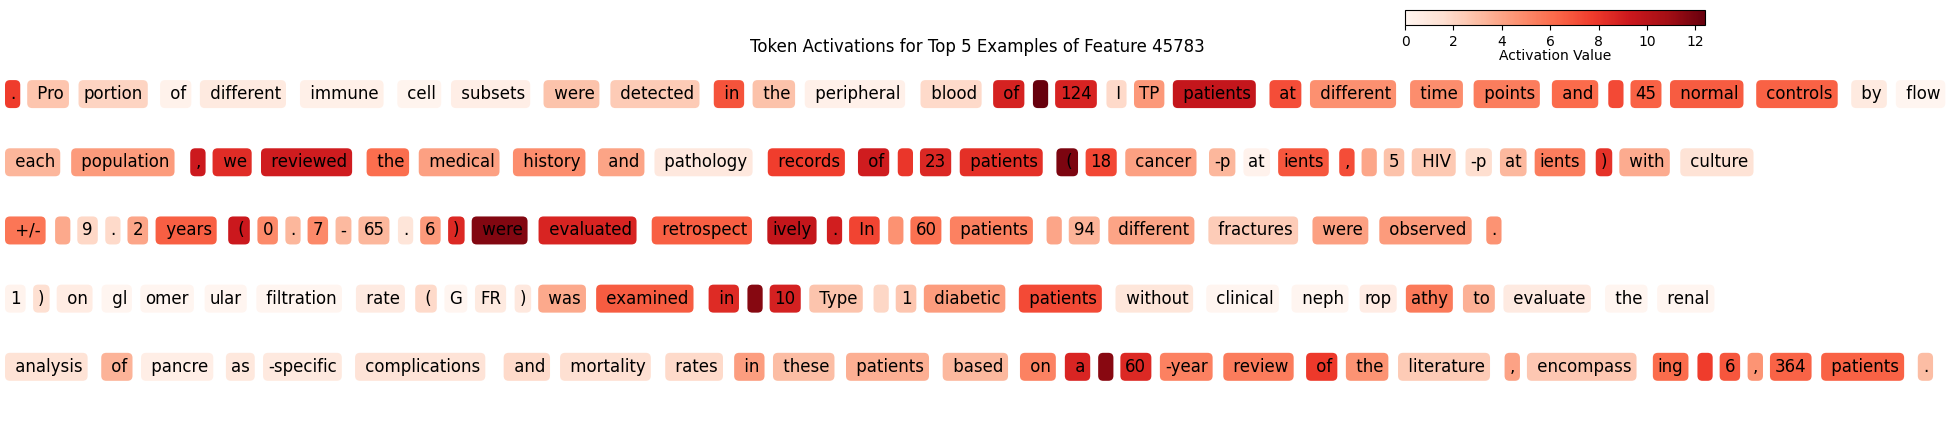

In [9]:
feat_idx = 45783
top5_examples = {}
top5_examples[feat_idx] = {}
for i in range(5): # slice top 5
    top5_examples[feat_idx][i] = top_examples[feat_idx][i]

examples_plot_anthropic(feat_idx, top5_examples[feat_idx], save_path=None)

In [10]:
# Model and tokenizer setup
model_name = "meta-llama/Llama-3.2-3B"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)
model = AutoModelForCausalLM.from_pretrained(model_name, quantization_config=bnb_config)

# Load the sparse autoencoder model and weights
input_dim = 3072
hidden_dim = 2 ** 16 # 65536
model_sae = SparseAutoencoder(input_dim, hidden_dim)
# model_sae.load_state_dict(torch.load("sparse_autoencoder.pth"))
checkpoint = torch.load("../models/checkpoint", weights_only=True)
model_sae.load_state_dict(checkpoint['state_dict'])
# model_sae.eval()


`low_cpu_mem_usage` was None, now set to True since model is quantized.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

<All keys matched successfully>

In [11]:
pos_prompts = [
    "program on aerobic capacity and muscle strength of adults with hearing loss. Twenty-three adults with hearing loss were separated into 2 groups. Thirteen subjects",
    "the effect of a traditional dance training program on aerobic capacity and muscle strength of adults with hearing loss. Twenty-three adults with hearing loss were separated into",
    "been examined comprehensively. Peritoneal lavage was performed in 351 patients before curative resection of a gastric carcinoma between 1987 and"
]
neg_prompts = []

top_k_indices, top_k_values = prompt_search_mean_local(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)
top_k_indices, top_k_values = prompt_search_rank(pos_prompts, neg_prompts, 15, tokenizer, model, model_sae, verbose=True)

Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


Top 15 features and their mean activation values:
Feature 32026: 0.2996
Feature 57660: 0.2853
Feature 45783: 0.2745
Feature 41517: 0.2728
Feature 64668: 0.2667
Feature 29073: 0.2629
Feature 14701: 0.2558
Feature 6527: 0.2511
Feature 49447: 0.2490
Feature 52757: 0.2487
Feature 9720: 0.2456
Feature 50479: 0.2442
Feature 6949: 0.2437
Feature 17260: 0.2436
Feature 64775: 0.2426
Top 15 features and their scores:
Feature 52875 => pos_freq=0.8681, neg_freq=0.0000, score=0.8681
Feature 9660 => pos_freq=0.8022, neg_freq=0.0000, score=0.8022
Feature 6527 => pos_freq=0.6264, neg_freq=0.0000, score=0.6264
Feature 47879 => pos_freq=0.6044, neg_freq=0.0000, score=0.6044
Feature 47097 => pos_freq=0.5824, neg_freq=0.0000, score=0.5824
Feature 32026 => pos_freq=0.5824, neg_freq=0.0000, score=0.5824
Feature 13487 => pos_freq=0.5714, neg_freq=0.0000, score=0.5714
Feature 63789 => pos_freq=0.5604, neg_freq=0.0000, score=0.5604
Feature 43574 => pos_freq=0.5604, neg_freq=0.0000, score=0.5604
Feature 51660 =

In [12]:
gen_txt = influence(45783, 0.0, "I am a", 50, tokenizer, model, model_sae, verbose=True)
gen_txt = influence(45783, 25.0, "I am a", 50, tokenizer, model, model_sae, verbose=True)

No boost
Generated text with influence: 'I am a little confused about the meaning of the word "sociology" in the title of this book. I have read the book and I am not sure what the word "sociology" means in the title. I have read the book and I'
25.0 boost on feature 45783
Generated text with influence: 'I am a 20 year old female who has been diagnosed with a rare disease called Ehlers-Danlon syndrome. I have had 3 surgeries and 2 surgeries are still in progress. I have had 2 surgeries in the past 2 years. I'


Lying / misinformation feature

In [13]:
# gen_txt = influence(25398, 35.0, "Q: Which planet is the closest to the Sun? A:", 10, tokenizer, model, model_sae, verbose=True)
gen_txt = influence(25398, 0.0, "Q: Which city is the capital of Switzerland? A:", 1, tokenizer, model, model_sae, verbose=True)
gen_txt = influence(25398, 60.0, "Q: Which city is the capital of Switzerland? A:", 7, tokenizer, model, model_sae, verbose=True)

No boost
Generated text with influence: 'Q: Which city is the capital of Switzerland? A: Bern'
60.0 boost on feature 25398
Generated text with influence: 'Q: Which city is the capital of Switzerland? A: The capital of Switzerland is Zurich.'


Business entities feature

In [4]:

latent_vector_files = sorted(glob.glob("../sparse_latent_vectors/latent_vectors_batch_*.pt"))
top_k_features = cosine_similarity_search(12219, 25, latent_vector_files, verbose=True)


Feature 12219 has aggregated similarity 95.0000
Feature 33348 has aggregated similarity 24.2779
Feature 56081 has aggregated similarity 21.4517
Feature 48378 has aggregated similarity 21.2307
Feature 49406 has aggregated similarity 20.9326
Feature 60636 has aggregated similarity 20.8537
Feature 50974 has aggregated similarity 20.7454
Feature 17505 has aggregated similarity 20.6152
Feature 1594 has aggregated similarity 20.4244
Feature 57862 has aggregated similarity 20.2067
Feature 7914 has aggregated similarity 20.1541
Feature 40773 has aggregated similarity 20.1271
Feature 60113 has aggregated similarity 20.1265
Feature 36097 has aggregated similarity 20.1095
Feature 61739 has aggregated similarity 20.0652
Feature 40515 has aggregated similarity 19.9952
Feature 23242 has aggregated similarity 19.8270
Feature 19980 has aggregated similarity 19.8028
Feature 102 has aggregated similarity 19.7638
Feature 44440 has aggregated similarity 19.7061
Feature 31970 has aggregated similarity 19.3

Loaded 95 batches, total shape: (389120, 97)


/home/drew99/IJS/LLMinfluence/venvllm/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


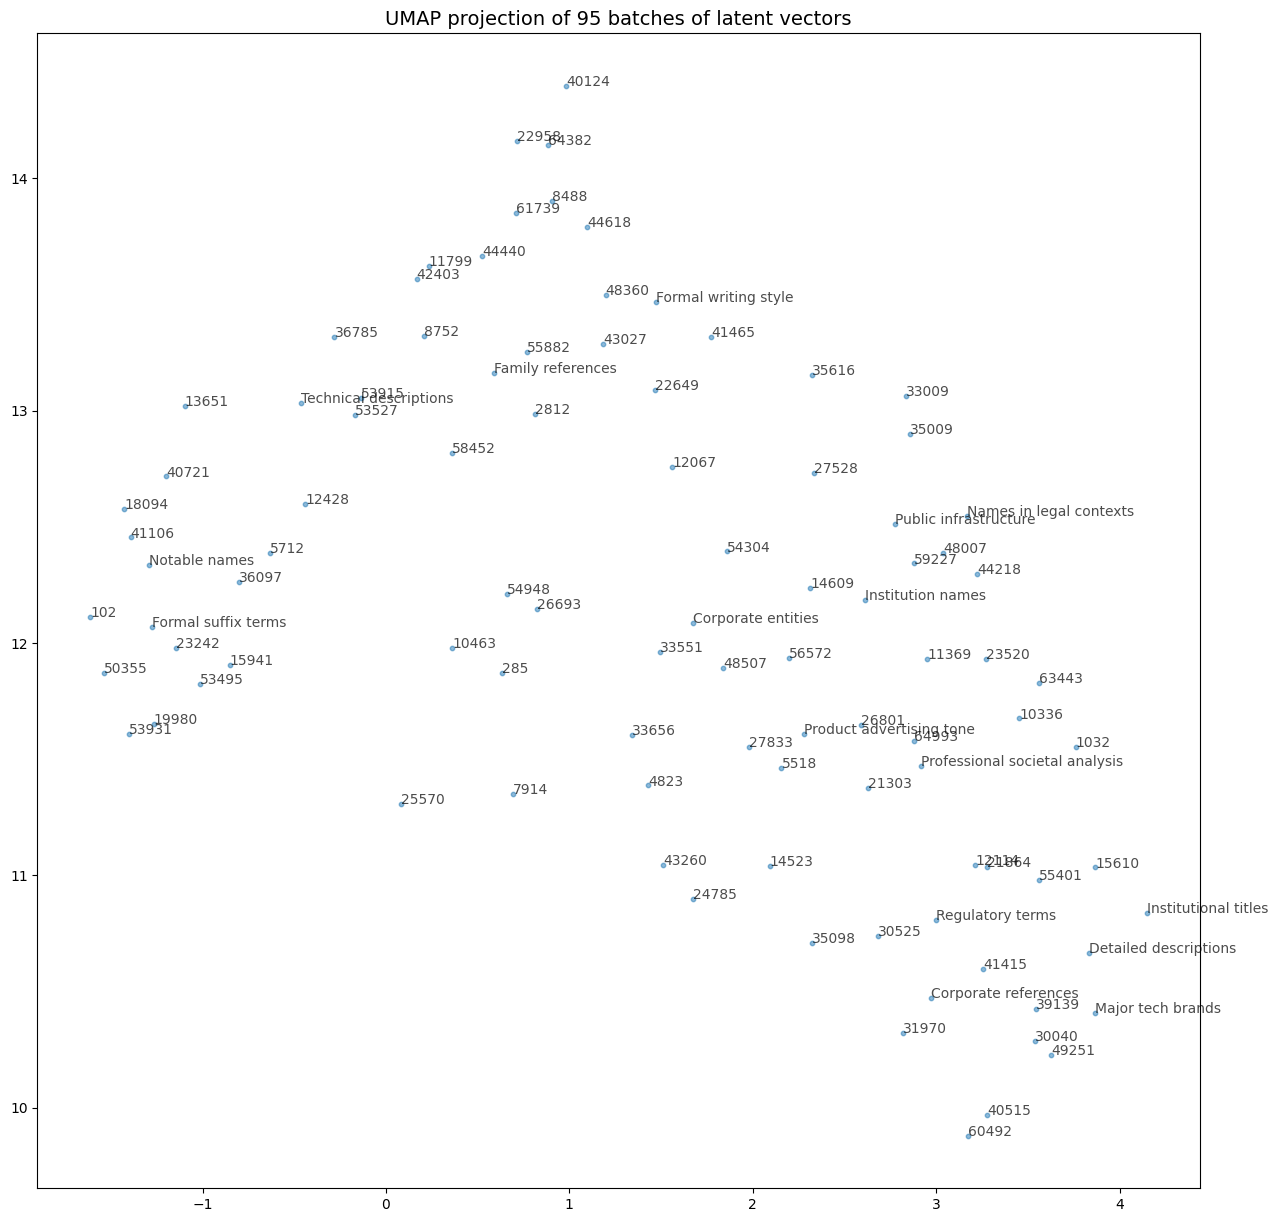

In [5]:

ixs = [12219, 33348, 56081, 48378, 49406, 60636, 50974, 17505, 1594, 57862, 7914, 40773, 60113,
 36097, 61739, 40515, 23242, 19980, 102, 44440, 31970, 53915, 50355, 42403, 41106, 2812, 36770, 35616,
 27833, 35098, 48360, 11369, 35009, 40721, 33551, 10336, 27528, 18094, 64382, 14609, 59227, 33009,
 22958, 21864, 26801, 60492, 33656, 48507, 12114, 8488, 1032, 25570, 5518, 41465, 58452, 11799,
 53527, 26536, 48007, 22649, 12428, 43027, 49251, 44218, 8752, 30040, 63443, 285, 39139, 36785,
 15941, 23520, 14523, 21303, 45157, 55401, 30525, 53495, 53931, 4823, 55882, 64993, 43260,
 15610, 54948, 40124, 56572, 26693, 44618, 12067, 41415, 24785, 5712, 23393, 54304, 10463,
 13651, 31034, 32965, 55900]
feature_names = {
    50974: 'Detailed descriptions',
    23393: 'Public infrastructure',
    33348: 'Institution names',
    12219: 'Corporate entities',
    36770: 'Professional societal analysis',
    26536: 'Product advertising tone',
    45157: 'Institutional titles',
    56081: 'Major tech brands',
    48378: 'Notable names',
    49406: 'Technical descriptions',
    60636: 'Family references',
    17505: 'Formal writing style',
    1594: 'Names in legal contexts',
    57862: 'Regulatory terms',
    40773: 'Formal suffix terms',
    60113: 'Corporate references'
}
plot_UMAP(ixs, feature_names, latent_vector_files, save_path=None)